In [1]:
import sys
import os
import pandas as pd
import numpy as np
import configparser
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import lightgbm as lgb
import lightgbm as lgb
from plotnine import ggplot, aes, geom_boxplot, labs, scale_color_manual, geom_point
import configparser
import random


project_root = "/home/dan1dr/zrive-ds-4q24-churn"

# Define the project root path
current_wd = os.getcwd()

# Change the working directory if necessary
if current_wd != project_root:
    print(f"Changing working directory from {current_wd} to {project_root}")
    os.chdir(project_root)
else:
    print("Already in the correct path")

# Add 'src' directory to sys.path
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    print(f"Adding {src_path} to sys.path")
    sys.path.insert(0, src_path)

# Import the modules
from db_connectors.bigquery_service import BigqueryService
from data_gathering import data_gathering
from utils.logger import get_logger
from data_cleaning import data_cleaning
from column_config import users_cols, diff_cols, keep_cols, transform_cols, target_col


config = configparser.ConfigParser()
config.read("src/params.ini")

logger = get_logger(__name__)


def get_initial_params():
    """
    Loads all relevant parameters into a global variable. These parameters are then accessible to other functions in the script.
    Each function can consume the parameters it requires for its operation.
    This approach ensures centralized management and consistency of parameters across different functions.

    Returns:
        None: This function does not return a value but populates a global variable
        with necessary parameters.
    """
    global train_from, train_to, end_date, logistic_regression_params, lightgbm_params

    config = configparser.ConfigParser()
    config.read("src/params.ini")

    train_from = config.get("PARAMS", "train_from")
    train_to = config.get("PARAMS", "train_to")
    end_date = config.get("PARAMS", "end_date")
    # Load Logistic Regression parameters
    logistic_regression_params = {
        "penalty": config.get("LOGISTIC_REGRESSION", "penalty", fallback="l2"),
        "C": config.getfloat("LOGISTIC_REGRESSION", "C", fallback=1.0),
        "solver": config.get("LOGISTIC_REGRESSION", "solver", fallback="saga"),
        "max_iter": config.getint("LOGISTIC_REGRESSION", "max_iter", fallback=10000),
    }

    # Load LightGBM parameters
    lightgbm_params = {
        "boosting_type": config.get("LIGHTGBM", "boosting_type", fallback="gbdt"),
        "num_leaves": config.getint("LIGHTGBM", "num_leaves", fallback=12),
        "max_depth": config.getint("LIGHTGBM", "max_depth", fallback=-1),
        "learning_rate": config.getfloat("LIGHTGBM", "learning_rate", fallback=0.005),
        "n_estimators": config.getint("LIGHTGBM", "n_estimators", fallback=100),
        "random_state": config.getint("LIGHTGBM", "random_state", fallback=500),
        "colsample_bytree": config.getfloat(
            "LIGHTGBM", "colsample_bytree", fallback=0.64
        ),
        "subsample": config.getfloat("LIGHTGBM", "subsample", fallback=0.7),
        "reg_alpha": config.getint("LIGHTGBM", "reg_alpha", fallback=0),
        "reg_lambda": config.getint("LIGHTGBM", "reg_lambda", fallback=1),
    }


get_initial_params()
save_curves_path = "src/models"
save_features_path = "src/features"
save_target_path = "src/target"

Changing working directory from /home/dan1dr/zrive-ds-4q24-churn/src/eda to /home/dan1dr/zrive-ds-4q24-churn
Adding /home/dan1dr/zrive-ds-4q24-churn/src to sys.path


In [2]:
get_initial_params()

In [141]:
def feature_computation(
    clean_data: pd.DataFrame,
    train_from: str,
    train_to: str,
    logger,
    keep_gap_month_churns: bool = False,
    save_features_path: str = "",
    save_target_path: str = "",
) -> (pd.DataFrame, pd.Series, pd.DataFrame, pd.Series):
    """
    Split data into train and test features set, aggregate the data into historical behavior for those cols needed.
    It also joins it with already calculated features, and extract the needed target from 2 months ahead.
    Args:
        clean_data: The cleaned dataset with customer, month, and payment information.
        train_from: The starting date of the training period.
        train_to: The ending date of the training period.

    Returns:
        DataFrame: Pandas DataFrame with computed features for model training.
        Series: Pandas Series representing the target variable for train set.
        DataFrame: Pandas DataFrame with computed features for model testing.
        Series: Pandas Series representing the target variable for test set.
    """
    logger.info("Starting feature computation")

    # TO-DO: Catch exceptions
    # TO-DO: Potential unit tests validating same length for features/targets
    # TO-DO: Instead of defining the cols every time import them somewhere else (they're need in data_cleaning also)

    # Convert the train_from and train_to to datetime
    train_from_dt = pd.to_datetime(train_from)
    train_to_dt = pd.to_datetime(train_to)

    # Filter train and test data before feature computation
    test_from_dt = train_from_dt + pd.DateOffset(months=1)
    test_to_dt = train_to_dt + pd.DateOffset(months=1)
    target_train_month = train_to_dt + pd.DateOffset(months=2)
    target_test_month = test_to_dt + pd.DateOffset(months=2)

    logger.info(
        f"Train computation from {train_from} to {train_to}. Target for {target_train_month}"
    )
    logger.info(
        f"Test computation from {test_from_dt} to {test_to_dt}. Target for {target_test_month}"
    )

    compute_ready_data = clean_data[
        users_cols + transform_cols + keep_cols + diff_cols + target_col
    ].copy()
    train_df, test_df = split_train_test(
        compute_ready_data, train_from_dt, train_to_dt, test_from_dt, test_to_dt
    )

    # For test set, we will remove all users that previously churned
    previous_churned_users_test = test_df[
        (test_df["date"] <= test_to_dt) & (test_df[target_col[0]] > 0)
    ]["customer_id"].unique()
    test_df = test_df[~test_df["customer_id"].isin(previous_churned_users_test)]

    logger.info(
        f"Removing {len(previous_churned_users_test)} previous churned users from test set"
    )

    logger.info(f"Unique customers in train: {train_df['customer_id'].nunique()}")
    logger.info(f"Unique customers in test: {test_df['customer_id'].nunique()}")

    logger.info("Starting features and target computation")
    logger.info(f"Initial number of features passed: {train_df.shape[1]}")
    logger.info("Starting computation")


    train_df_features = compute_features(train_df, target_col)
    test_df_features = compute_features(test_df, target_col)
    train_df_target = compute_target(train_df_features,
        compute_ready_data, target_col, keep_gap_month_churns
    )
    test_df_target = compute_target(test_df_features,
        compute_ready_data, target_col, keep_gap_month_churns
    )
    logger.info(f"Final number of features computed: {train_df_features.shape[1]}")
    logger.info(f"Length train data: {len(train_df_features)}")
    logger.info(f"Length test data: {len(test_df_features)}")
    logger.info("Computation done!")

    # As there are customer that leave between the month we use for training and the target month
    # We have to join the features and the targets and drop those that don't have target. By doing this,
    # we exclude customer that churned in gap month or those with no corresponding record in the target dataset.
    features_and_target_train = train_df_features.merge(
        train_df_target, on="customer_id", how="left"
    )
    features_and_target_test = test_df_features.merge(
        test_df_target, on="customer_id", how="left"
    )    
    
    features_and_target_train = features_and_target_train[
        features_and_target_train[target_col[0]].notna()
    ]

    features_and_target_test = features_and_target_test[
        features_and_target_test[target_col[0]].notna()
    ]
    
    date_cols = ['date', 'target_month', 'gap_month', 'cutoff_date']

    # Split train and test features + target (squeeze into 1D array)
    features = features_and_target_train.drop(columns=target_col + users_cols + date_cols)
    features_test = features_and_target_test.drop(columns=target_col + users_cols + date_cols)
    target = features_and_target_train[target_col].squeeze()
    target_test = features_and_target_test[target_col].squeeze()

    logger.info(f"Features: {features.columns.tolist()}")
    logger.info(f"Target: {target.name}")
    logger.info("Completed feature computation!")


    try:
        features.to_parquet(f"{save_features_path}/features.parquet", index=False)
        features_test.to_parquet(
            f"{save_features_path}/features_test.parquet", index=False
        )
        target.to_frame().to_parquet(f"{save_target_path}/target.parquet", index=False)
        target_test.to_frame().to_parquet(
            f"{save_target_path}/target_test.parquet", index=False
        )
        logger.info(f"Features saved on {save_features_path}")
        logger.info(f"Targets saved on {save_target_path}")
    except:
        logger.info(f"Features not saved on {save_features_path}")
        logger.info(f"Targets not saved on {save_target_path}")

    return features, target, features_test, target_test



def split_train_test(
    df: pd.DataFrame,
    train_from_dt: pd.Series,
    train_to_dt: pd.Series,
    test_from_dt: pd.Series,
    test_to_dt: pd.Series,
    window_months: int = 6,
) -> (pd.DataFrame, pd.DataFrame):
    """
    Split data into train and test and randomly assigns a specific month for each of the users.
    Args:
        df: The clean dataset with the columns we want to use as features.
        train_from: The starting date of the training period.
        train_to: The ending date of the training period.
        test_from: The starting date of the testing period.
        test_to: The ending date of the testing period.

    Returns:
        DataFrame: Pandas DataFrame with training months only.
        DataFrame: Pandas DataFrame with testing months only.
    """
    # Create date col to mix month and year
    window = pd.DateOffset(months=window_months)
    df["date"] = pd.to_datetime(
        df["YEAR"].astype(str) + "-" + df["MONTH"].astype(str) + "-01"
    )

    # Filter compute_data for the specific date intervals.
    df = df[(df["date"] >= train_from_dt - window) & (df["date"] <= test_to_dt)]

    train_df = df[(df["date"] >= train_from_dt) & (df["date"] <= train_to_dt)]
    test_df = df[(df["date"] >= test_from_dt) & (df["date"] <= test_to_dt)]

    selected_train_df = (
        train_df.groupby('customer_id')['date']
        .apply(lambda x: random.choice(x.unique()))
        .reset_index()
        .rename(columns={'date': 'cutoff_date'})
    )
    
    train_df = df.merge(selected_train_df, how='inner', on=['customer_id'])
    train_df = train_df[(train_df['date'] <= train_df['cutoff_date']
                         ) & (train_df['date'] > (train_df['cutoff_date'] - window))]
    
    # Set the cutoff date to test_to_dt for all test data    
    test_df['cutoff_date'] = test_to_dt

    return train_df, test_df

def compute_features(
    df: pd.DataFrame, target_col: list[str]) -> pd.DataFrame:
    """
    Compute the features and adds them to the df.
    Args:
        df: The clean dataset with the columns we want to use as features.
        target_col: Name of the target column.
        add_churn_label: Whether to add the 'WHEN_USER_CHURNED' column.

    Returns:
        DataFrame: Pandas DataFrame with new computed variables.
    """

    # TO-DO: The rolling function is propagated backwards for each single month.
    # we just need it for the last one (but for that we need past data also). Didn't find
    # any option to do it with pandas

    #df = df.drop(columns=target_col)

    df = df.sort_values(by=["customer_id", "date"])
    df = df.set_index("date")

    # Dynamically compute features for each col in transform_cols
    for col in transform_cols:
        df[f"{col}_prev_month"] = df.groupby("customer_id")[col].shift(1)
        df[f"{col}_prev_month"] = df[f"{col}_prev_month"].fillna(0)
        df[f"{col}_avg_3_months"] = compute_x_months_avg(df, col, 3)
        df[f"{col}_avg_6_months"] = compute_x_months_avg(df, col, 6)
        df[f"{col}_std_3_months"] = compute_x_months_std(df, col, 3)
        df[f"{col}_std_6_months"] = compute_x_months_std(df, col, 6)
    
    df = df.reset_index().drop(columns=target_col)
    df = df[df['date'] == df['cutoff_date']]


    return df


def compute_x_months_avg(
    df: pd.DataFrame, col_name: list[str], months: int
) -> pd.DataFrame:
    """
    Compute the mean of the last months for a column.
    Args:
        df: The clean dataset with the columns we want to use as features.
        col_name: Name of the column to compute
        months: Number of months we want to compute the feature back

    Returns:
        DataFrame: Pandas DataFrame the new computed column.
    """
    return (
        df.groupby("customer_id")[col_name]
        .rolling(window=months, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )


def compute_x_months_std(
    df: pd.DataFrame, col_name: list[str], months: int
) -> pd.DataFrame:
    """
    Compute the mean of the last months for a column.
    Args:
        df: The clean dataset with the columns we want to use as features.
        col_name: Name of the column to compute
        months: Number of months we want to compute the feature back

    Returns:
        DataFrame: Pandas DataFrame the new computed column.
    """
    return (
        df.groupby("customer_id")[col_name]
        .rolling(window=months, min_periods=1)
        .std()
        .reset_index(level=0, drop=True)
    )


def compute_target(
    df: pd.DataFrame,
    compute_ready_data: pd.DataFrame,
    target_col: list[str],
    keep_gap_month_churns: bool = False,
) -> pd.DataFrame:
    """
    Compute the target column for a df.
    Args:
        df: The clean dataset with all the data.
        target_col: Name of the target column.
        target_month: The date where the target has to be computed.
        keep_gap_month_churns: A boolean parameter that determines the treatment of churns occurring in the gap month.
        If True, these churns are treated as actual churns (assigned a value of 1);
        otherwise, they are excluded from the analysis. Defaults to False.
    Returns:
        DataFrame: Pandas DataFrame with the customer_id and the target computed.
    """

    df['target_month'] = df['date'] + pd.DateOffset(months=2)
    df['gap_month'] = df['date'] + pd.DateOffset(months=1)

    # Create two separate DataFrames for target_month and gap_month
    df_target = df[['customer_id', 'target_month']].copy()
    df_target['reference_date'] = df_target['target_month']

    df_gap = df[['customer_id', 'gap_month']].copy()
    df_gap['reference_date'] = df_gap['gap_month']

    # Combine the target and gap month DataFrames
    combined_df = pd.concat([df_target, df_gap], ignore_index=True)

    # Merge with compute_ready_data
    target_df = compute_ready_data.merge(combined_df, 
                                         left_on=['customer_id', 'date'], 
                                         right_on=['customer_id', 'reference_date'])

    for col in target_col:
        target_df[col].fillna(0, inplace=True)
        target_df[col] = np.where(
            ((target_df[col] > 0) & (target_df["date"] == target_df["target_month"])),
            1,
            target_df[col],
        )
        target_df[col] = np.where(
            ((target_df[col] > 0) & (target_df["date"] == target_df['gap_month'])),
            2,
            target_df[col],
        )

    if keep_gap_month_churns:
        # Convert all values that are 2 (gap month churns) into 1 (real churns)
        target_df[col] = np.where(target_df[col] == 2, 1, target_df[col])

    # Add categorical data for churned month
    target_df = add_month_churned_column(target_df, target_col)
    target_df['WHICH_MONTH_CHURNED'] = target_df['WHICH_MONTH_CHURNED'].astype("category")

    # Exclude the records that are still marked as 2 (gap month churns) if keep_gap_month_churns is False
    target_df = target_df[
        (target_df["NUM_DAYS_LINE_TYPE_FIXE_POST_DEA"] != 2)
        & (target_df["date"] != target_df['gap_month'])
    ][["customer_id", "WHICH_MONTH_CHURNED"] + target_col]

    #target_df = add_month_churned_column(df)

    target_df[target_col] = target_df[target_col].astype("int")

    return target_df

def add_month_churned_column(df: pd.DataFrame, target_col: list[str]) -> pd.DataFrame:
    """ 
    Add a column indicating the month in which churn occurred.
    """
    month_to_letter = {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 
                       7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L',
                       }

    # For each target column, determine the churn month
    for col in target_col:
        df['WHICH_MONTH_CHURNED'] = np.where(
            df[col] == 1, df['target_month'].dt.month.map(month_to_letter),
            np.nan  # Assign NaN if not churned in target month
        )

    return df

In [142]:
    query = f"""
        WITH all_periods AS
        (
            SELECT *
            FROM   `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
            UNION ALL
            SELECT *
            FROM   `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1` ), selectable_customer AS
        (
                SELECT   customer_id
                FROM     all_periods
                GROUP BY customer_id ), customer_selected AS
        (
            SELECT customer_id AS selected_customer
            FROM   selectable_customer
            WHERE  MOD(ABS(FARM_FINGERPRINT(CAST(customer_id AS STRING))), 10) < 2 )
        SELECT     {", ".join(diff_cols + keep_cols + users_cols + target_col + transform_cols)}
        FROM       all_periods
        INNER JOIN customer_selected
        ON         customer_id = selected_customer
        WHERE      IS_CUST_SEGM_RESI > 0
        AND        IS_CUST_BILL_POST_CURR = TRUE
        AND        CUST_BUNDLE_CURR = 'FMC'
        AND        NUM_IMPAGOS = 0
        AND        pago_final_0 IS NOT NULL
    """
    

In [147]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import lightgbm as lgb


def modeling(
    features: pd.DataFrame, target: pd.Series, lightgbm_params, logger
) -> Pipeline:
    """
    Prepares a machine learning pipeline that scales features and trains a logistic regression model
    with processed data to predict churn.

    Args:
        features (pd.DataFrame): The features to train the model on.
        target (pd.Series): The target variable to predict.

    Returns:
        Pipeline: A pipeline with a standard scaler and a trained logistic regression model.
    """

    logger.info("Starting Modeling")

    # Convert Categoricals
    features['WHICH_MONTH_CHURNED'] = features['WHICH_MONTH_CHURNED'].astype('category')

    # Directly use the logistic_regression_params global variable
    logger.info("Building model pipeline")
    """
    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "logistic_regression",
                LogisticRegression(
                    penalty=logistic_regression_params["penalty"],
                    C=logistic_regression_params["C"],
                    solver=logistic_regression_params["solver"],
                    max_iter=logistic_regression_params["max_iter"],
                    random_state=42,
                ),
            ),
        ]
    )"""
    pipeline = Pipeline(
        [
            (
                "lightgbm",
                lgb.LGBMClassifier(
                    learning_rate=lightgbm_params["learning_rate"],
                    n_estimators=lightgbm_params["n_estimators"],
                    num_leaves=lightgbm_params["num_leaves"],
                    colsample_bytree=lightgbm_params["colsample_bytree"],
                    subsample=lightgbm_params["subsample"],
                    reg_alpha=lightgbm_params["reg_alpha"],
                    reg_lambda=lightgbm_params["reg_lambda"],
                    random_state=lightgbm_params["random_state"],
                ),
            ),
        ]
    )

    logger.info("Training model")
    model = pipeline.fit(features, target)

    logger.info("Completed model training!")

    return model

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
from datetime import datetime
import os


def evaluation(
    model,
    features_test: pd.DataFrame,
    target_test: pd.Series,
    logger,
    save_curves_path,
) -> dict[str, str]:
    """
    Assesses trained model's performance using a test dataset and computes metrics like accuracy, precision, recall, and ROC-AUC.

    Returns:
        dict: Dictionary with key performance metrics of the model.
    """
    logger.info(f"Started evaluation for {model}")
    preds = model.predict_proba(features_test)[:, 1]

    # Plotting
    logger.info("Generating plots")

    generate_evaluation_curves(
        model,
        preds,
        target_test,
        save_curves_path,
    )

    precision, recall, _ = precision_recall_curve(target_test, preds)
    model_metrics = {
        "Precision Curve": precision,
        "Recall Curve": recall,
        # "ROC AUC": roc_auc
    }

    # Calculate Precision in the First Decile
    precision_decile = calculate_precision_first_decile(target_test, preds)
    logger.info(f"Precision in the first decile: {precision_decile:.2f}")

    # Calculate Uplift for Each Decile
    uplift_by_decile = calculate_uplift(target_test, preds)
    logger.info("Uplift by decile:")
    logger.info(uplift_by_decile)

    logger.info("Completed evaluation!")

    model_name = type(model["lightgbm"]).__name__

    if model_name == "LGBMClassifier":
        feature_importance = get_feature_importance_lightgbm(model, features_test)
    else:
        feature_importance = get_feature_importance_logistic_regression(
            model, features_test
        )

    logger.info("Feature importance")
    logger.info(feature_importance.head(10))

    return model_metrics, precision_decile, uplift_by_decile, feature_importance


def calculate_precision_first_decile(target, y_pred_proba):
    """
    Calculate the precision in the first decile of predictions.

    Args:
    - y_true (array-like): True labels.
    - y_pred_proba (array-like): Predicted probabilities.

    Returns:
    - precision_decile (float): Precision in the first decile.
    """
    data = pd.DataFrame({"y_true": target, "y_pred_proba": y_pred_proba})
    data_sorted = data.sort_values(by="y_pred_proba", ascending=False)
    decile_cutoff = int(len(data_sorted) * 0.1)
    first_decile = data_sorted.head(decile_cutoff)
    true_positives = first_decile["y_true"].sum()
    precision_decile = true_positives / decile_cutoff

    return precision_decile


def calculate_uplift(target, y_pred_proba):
    """
    Calculate the uplift for each decile.

    Args:
    - y_true (array-like): True labels.
    - y_pred_proba (array-like): Predicted probabilities.

    Returns:
    - pd.Series: Uplift for each decile.
    """
    data = pd.DataFrame({"y_true": target, "y_pred_proba": y_pred_proba})
    data_sorted = data.sort_values(by="y_pred_proba", ascending=False)
    try:
        data_sorted["decile"] = pd.qcut(data_sorted["y_pred_proba"], q=10, labels=list(reversed(range(10))))
    except ValueError:
        # Handle fewer bins than desired
        bins = pd.qcut(data_sorted["y_pred_proba"], q=137, duplicates='drop').categories
        unique_bins = len(bins)
        labels = list(reversed(range(unique_bins-1)))  # Create one less label
        data_sorted["decile"] = pd.qcut(data_sorted["y_pred_proba"], q=unique_bins, labels=labels, duplicates='drop')
    decile_churn_rate = data_sorted.groupby("decile", observed=True)["y_true"].mean()

    overall_churn_rate = data["y_true"].mean()
    uplift = decile_churn_rate / overall_churn_rate

    # return by ascending deciles
    return uplift.sort_index(ascending=False)


def generate_evaluation_curves(
    model: str, y_pred, y_test, save_curves_path: str = None
):
    """
    Generate ROC and Precision-Recall curves for a binary classification model
    and save them in a single figure.

    Parameters:
    - model_name (str): Name of the model for labeling the curves.
    - y_pred (array-like): Predicted probabilities or scores.
    - y_test (array-like): True labels.
    - save_curves_path (str, optional): Directory to save the generated figure.
    If None, the figure will not be saved.

    Returns:
    - None
    """

    # Create a timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y_%m_%d")
    model_type = type(model[-1]).__name__  # Assuming 'model' is your pipeline

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f}) - {model_type}")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC")
    plt.legend(loc="lower right")

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"PR (AUC = {pr_auc:.2f}) - {model_type}")
    plt.xlim([-0.005, 1.0])  # Adjusted to start slightly before 0 for a clearer view
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="upper right")

    plt.tight_layout()

    if save_curves_path:
        # Define the filename with a timestamp
        figure_filename = f"Evaluation_Curves_{timestamp}.png"
        figure_path = os.path.join(save_curves_path, figure_filename)

        plt.savefig(figure_path)

    plt.show()


def get_feature_importance_logistic_regression(model, features):
    """
    Get feature importance for Logistic Regression model.

    Args:
    - model: Trained Logistic Regression model.
    - feature_names (list or array-like): List of feature names.

    Returns:
    - pd.DataFrame: DataFrame containing feature names and their corresponding coefficients.
    """
    feature_names = features.columns
    # Extract coefficients
    lr_model = model.named_steps["logistic_regression"]
    coefficients = lr_model.coef_[0]  # for Logistic Regression

    # Create a DataFrame for easy visualization
    feature_importance = pd.DataFrame(
        {"Feature": feature_names, "Coefficient": coefficients}
    )

    # Sort by absolute value of coefficients in descending order
    feature_importance = feature_importance.reindex(
        feature_importance.Coefficient.abs().sort_values(ascending=False).index
    )

    return feature_importance


def get_feature_importance_lightgbm(model, features):
    """
    Get feature importance for Lightgbm model.

    Args:
    - model: Trained Lightgbm model.
    - feature_names (list or array-like): List of feature names.

    Returns:
    - pd.DataFrame: DataFrame containing feature names and their corresponding coefficients.
    """
    feature_names = features.columns
    # Extract coefficients
    lr_model = model.named_steps["lightgbm"]
    coefficients = lr_model.feature_importances_

    # Create a DataFrame for easy visualization
    feature_importance = pd.DataFrame(
        {"Feature": feature_names, "Coefficient": coefficients}
    )

    # Sort by absolute value of coefficients in descending order
    feature_importance = feature_importance.reindex(
        feature_importance.Coefficient.abs().sort_values(ascending=False).index
    )

    return feature_importance

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 1019032
INFO - Starting cleaning data
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column Import_Rest_quota_disp
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column NUM_FIX_PORT
INFO - Dropping column NUM_FIX_PORT_LAST_1_MONTH
INFO - Dropping column NUM_FIX_PORT_LAST_3_MONTHS
INFO - Dropping 

[LightGBM] [Info] Number of positive: 1523, number of negative: 47773
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68460
[LightGBM] [Info] Number of data points in the train set: 49296, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030895 -> initscore=-3.445779
[LightGBM] [Info] Start training from score -3.445779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


INFO - Generating plots


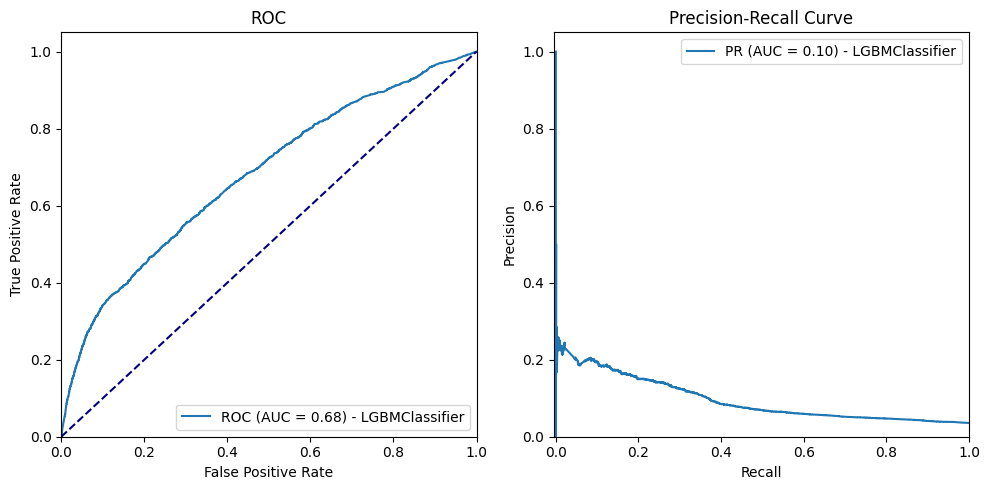

INFO - Precision in the first decile: 0.12
/tmp/ipykernel_482/2046921147.py:175: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.258897
1    1.110391
2    1.067158
3    0.914569
4    0.814285
5    0.802512
6    0.670169
7    0.445159
8    0.557436
9    0.369577
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                          Feature  Coefficient
351          WHICH_MONTH_CHURNED          192
112                NUM_PERM_CURR           28
160  service_fix_pending_install           25
151   dif_periodica_prev_2_month           23
38            MIN_DAYS_PERM_CURR           21
0                   pago_final_0           21
77                   NUM_DUR_OBJ           15
150     dif_periodica_prev_month           14

In [144]:
get_initial_params()
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)
features, target, features_test, target_test = feature_computation(
    clean_data,
    train_from,
    train_to,
    logger,
    save_features_path=save_features_path,
    save_target_path=save_target_path,
)
model = modeling(features, target, lightgbm_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path
)

Now for last 23 month available

In [146]:
def calculate_uplift(target, y_pred_proba):
    """
    Calculate the uplift for each decile.

    Args:
    - y_true (array-like): True labels.
    - y_pred_proba (array-like): Predicted probabilities.

    Returns:
    - pd.Series: Uplift for each decile.
    """
    data = pd.DataFrame({"y_true": target, "y_pred_proba": y_pred_proba})
    data_sorted = data.sort_values(by="y_pred_proba", ascending=False)
    try:
        data_sorted["decile"] = pd.qcut(data_sorted["y_pred_proba"], q=10, labels=list(reversed(range(10))))
    except ValueError:
        # Handle fewer bins than desired
        bins = pd.qcut(data_sorted["y_pred_proba"], q=137, duplicates='drop').categories
        unique_bins = len(bins)
        labels = list(reversed(range(unique_bins-1)))  # Create one less label
        data_sorted["decile"] = pd.qcut(data_sorted["y_pred_proba"], q=unique_bins, labels=labels, duplicates='drop')
    decile_churn_rate = data_sorted.groupby("decile", observed=True)["y_true"].mean()

    overall_churn_rate = data["y_true"].mean()
    uplift = decile_churn_rate / overall_churn_rate

    # return by ascending deciles
    return uplift.sort_index(ascending=False)

def evaluate_metrics_lgb(y_true, y_pred, n_trees, lr, max_depth, path_smooth, train_or_test="test"):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    uplift = calculate_uplift(y_true, y_pred)

    print(
        f"LGBM with n_trees {n_trees} n of trees and lr {lr}  and depth {max_depth} and reg {path_smooth} on {train_or_test}: Roc AUC {roc_auc:.4f} and PR AUC {pr_auc:.4f}"
    )

    print(
        f"LGBM with n_trees {n_trees} n of trees and lr {lr}  and depth {max_depth} and reg {path_smooth} on {train_or_test} {uplift[0]} Uplift on the first decile"
    )
    print(uplift)

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 1019032
INFO - Starting cleaning data
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column Import_Rest_quota_disp
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column NUM_FIX_PORT
INFO - Dropping column NUM_FIX_PORT_LAST_1_MONTH
INFO - Dropping column NUM_FIX_PORT_LAST_3_MONTHS
INFO - Dropping 

[LightGBM] [Info] Number of positive: 1892, number of negative: 48757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.246058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68429
[LightGBM] [Info] Number of data points in the train set: 50649, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037355 -> initscore=-3.249214
[LightGBM] [Info] Start training from score -3.249214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


INFO - Generating plots


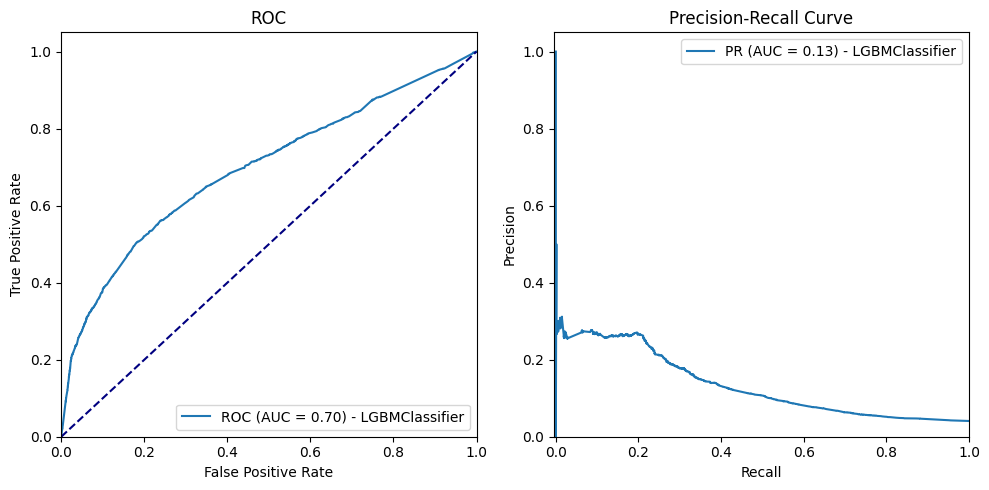

INFO - Precision in the first decile: 0.15


ValueError: Bin edges must be unique: array([0.02507509, 0.02524017, 0.02524017, 0.02543771, 0.02560515,
       0.02597802, 0.02609761, 0.02617076, 0.02631692, 0.02654081,
       0.0446491 ]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [145]:
get_initial_params()
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)
features, target, features_test, target_test = feature_computation(
    clean_data,
    train_from,
    train_to,
    logger,
    save_features_path=save_features_path,
    save_target_path=save_target_path,
)
model = modeling(features, target, lightgbm_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path
)

INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


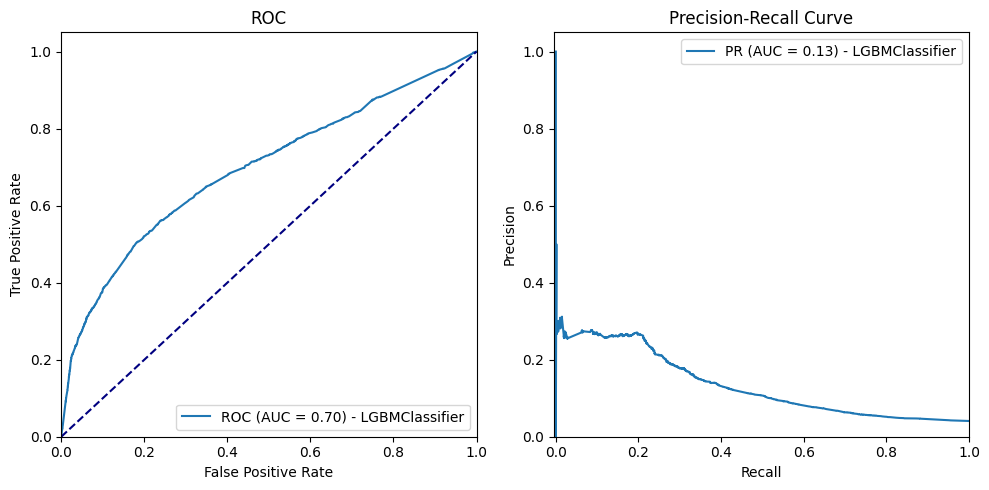

INFO - Precision in the first decile: 0.15


AttributeError: 'Series' object has no attribute 'categories'

In [149]:
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path)

In [136]:
import sys
import os
import pandas as pd
import numpy as np
import configparser
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import lightgbm as lgb
import lightgbm as lgb
from plotnine import ggplot, aes, geom_boxplot, labs, scale_color_manual, geom_point

(40110,)

In [ ]:
lr = 0.1
n_estimators = 100
max_depth = 10
path_smooth = 0
metric = "binary"

In [150]:
model = lgb.LGBMClassifier(
                    learning_rate=lightgbm_params["learning_rate"],
                    n_estimators=lightgbm_params["n_estimators"],
                    num_leaves=lightgbm_params["num_leaves"],
                    colsample_bytree=lightgbm_params["colsample_bytree"],
                    subsample=lightgbm_params["subsample"],
                    reg_alpha=lightgbm_params["reg_alpha"],
                    reg_lambda=lightgbm_params["reg_lambda"],
                    random_state=lightgbm_params["random_state"],
                
)

model.fit(features, target,
    eval_set=[(features, target), (features_test, target_test)],
        eval_metric = 'logloss',
)
         
evals_result = model.evals_result_

[LightGBM] [Info] Number of positive: 1892, number of negative: 48757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68429
[LightGBM] [Info] Number of data points in the train set: 50649, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037355 -> initscore=-3.249214
[LightGBM] [Info] Start training from score -3.249214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [151]:
def compute_learning_rate(evals_result, set_) -> pd.DataFrame:
    """
    Calculate the normalized learning rates for the model

    Parameters:
    - set_ (str): The dataset type ('training' or 'valid_0').
    - all_results (dict): Dictionary containing training results for each execution date.

    Returns:
    - pd.DataFrame: DataFrame with normalized learning rates, including execution dates and tree categories.
    """

    train_logloss = evals_result[set_]['binary_logloss']
    df = pd.DataFrame({'binary_logloss': train_logloss, 'set': set_})

    # Combine dataframes
    df['n_trees'] = range(len(df))

    # Calculate the % diff respect to first tree
    df["first_tree_logloss"] = df["binary_logloss"].iloc[0]
    df["normalized_learning_rate"] = (df["binary_logloss"] - df["first_tree_logloss"]) / df["first_tree_logloss"]
    df = df.drop(columns="first_tree_logloss")

    return df

learning_rates_train = compute_learning_rate(evals_result, 'training')
learning_rates_test = compute_learning_rate(evals_result, 'valid_1')

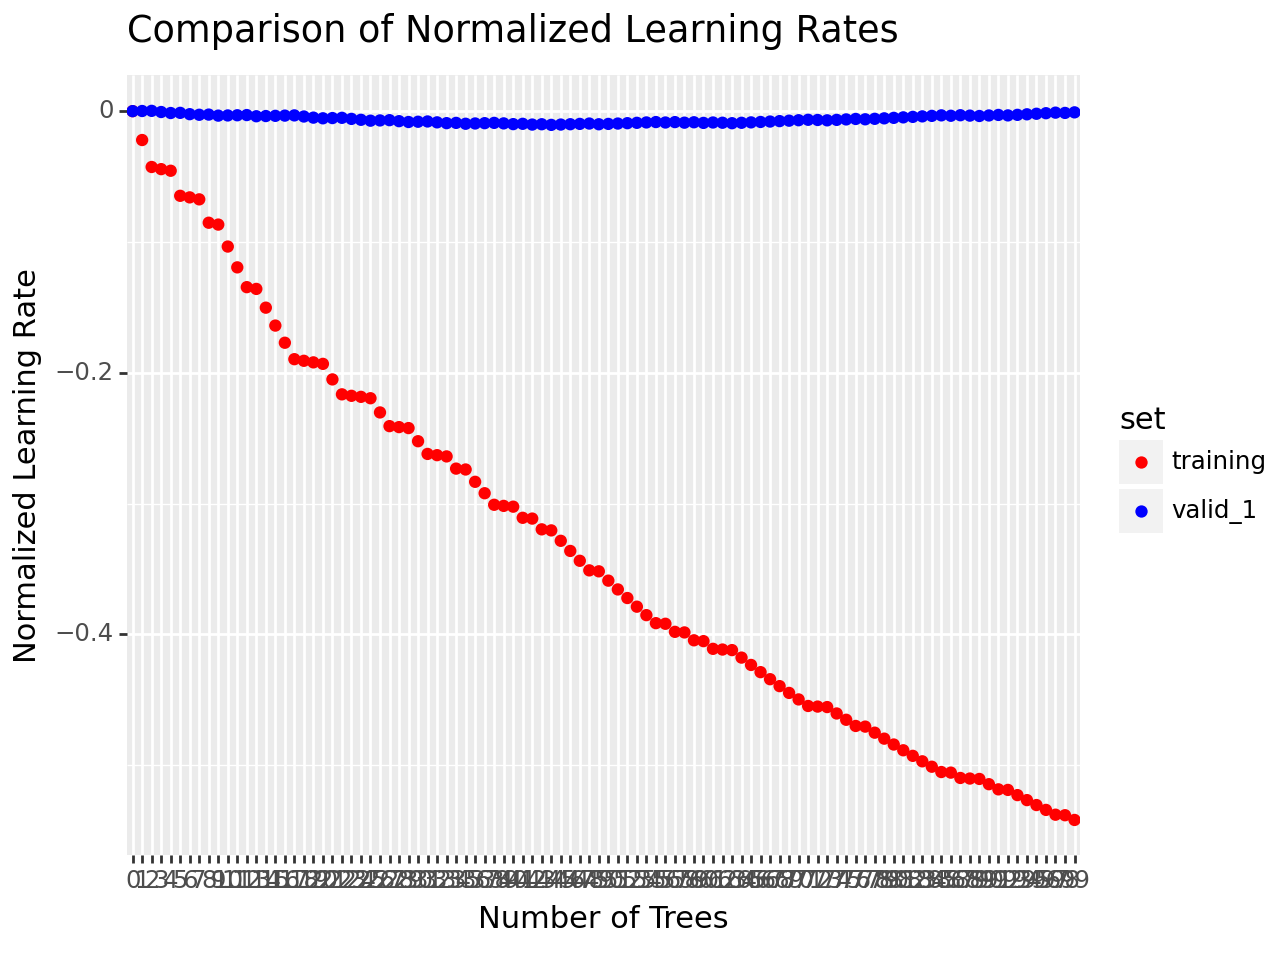

In [152]:
learning_rates_train = compute_learning_rate(evals_result, 'training')
learning_rates_test = compute_learning_rate(evals_result, 'valid_1')

#learning_rates_train = learning_rates_train[learning_rates_train['n_trees'] <= 75]
#learning_rates_test= learning_rates_test[learning_rates_test['n_trees'] <= 75]


combined_data = pd.concat([learning_rates_train, learning_rates_test])

combined_data["n_trees_cat"] = pd.Categorical(
    combined_data["n_trees"],
    categories=sorted(combined_data["n_trees"].unique()),
)


plot = (
    ggplot(combined_data, aes(x='n_trees_cat', y='normalized_learning_rate', color='set')) +
    geom_point() +
    labs(title='Comparison of Normalized Learning Rates',
         x='Number of Trees',
         y='Normalized Learning Rate') +
    scale_color_manual(values=["red", "blue"])
)

print(plot)

In [165]:
model = lgb.LGBMClassifier(
                    learning_rate=0.001,
                    n_estimators=lightgbm_params["n_estimators"],
                    num_leaves=20,
                    colsample_bytree=lightgbm_params["colsample_bytree"],
                    subsample=lightgbm_params["subsample"],
                    reg_alpha=lightgbm_params["reg_alpha"],
                    reg_lambda=lightgbm_params["reg_lambda"],
                    random_state=lightgbm_params["random_state"],
                    max_depth=5,
                    path_smooth=1,
                
)

model.fit(features, target,
    eval_set=[(features, target), (features_test, target_test)],
        eval_metric = 'logloss',
)
         
evals_result = model.evals_result_

[LightGBM] [Info] Number of positive: 1892, number of negative: 48757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68429
[LightGBM] [Info] Number of data points in the train set: 50649, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037355 -> initscore=-3.249214
[LightGBM] [Info] Start training from score -3.249214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

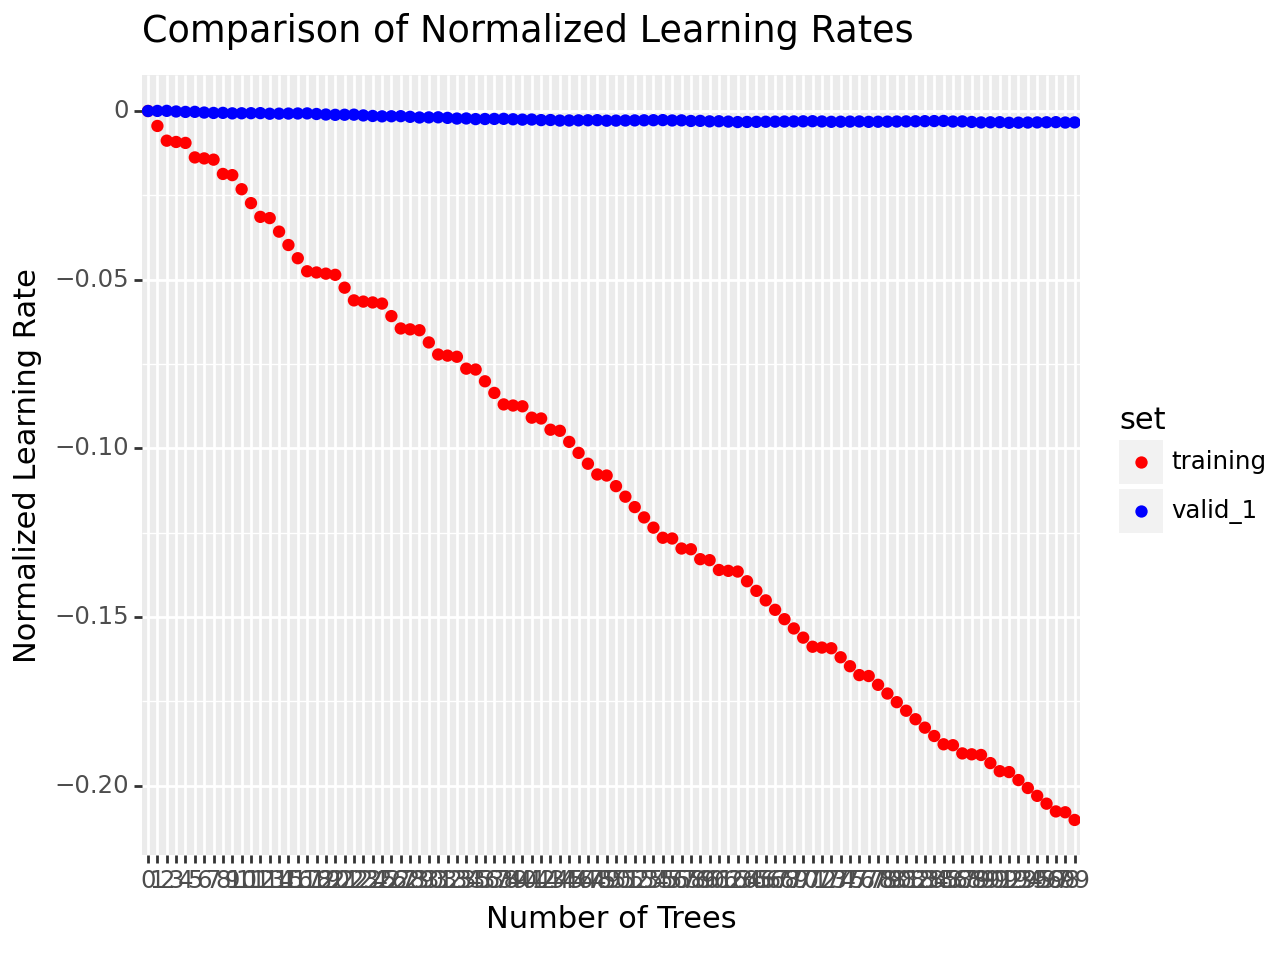

In [166]:
learning_rates_train = compute_learning_rate(evals_result, 'training')
learning_rates_test = compute_learning_rate(evals_result, 'valid_1')

#learning_rates_train = learning_rates_train[learning_rates_train['n_trees'] <= 75]
#learning_rates_test= learning_rates_test[learning_rates_test['n_trees'] <= 75]


combined_data = pd.concat([learning_rates_train, learning_rates_test])

combined_data["n_trees_cat"] = pd.Categorical(
    combined_data["n_trees"],
    categories=sorted(combined_data["n_trees"].unique()),
)


plot = (
    ggplot(combined_data, aes(x='n_trees_cat', y='normalized_learning_rate', color='set')) +
    geom_point() +
    labs(title='Comparison of Normalized Learning Rates',
         x='Number of Trees',
         y='Normalized Learning Rate') +
    scale_color_manual(values=["red", "blue"])
)

print(plot)

INFO - Starting feature computation
INFO - Train computation from 2022-12-01 to 2023-05-01. Target for 2023-07-01 00:00:00
INFO - Test computation from 2023-01-01 00:00:00 to 2023-06-01 00:00:00. Target for 2023-08-01 00:00:00
/tmp/ipykernel_482/2080027226.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO - Removing 9564 previous churned users from test set
INFO - Unique customers in train: 53193
INFO - Unique customers in test: 43812
INFO - Starting features and target computation
INFO - Initial number of features passed: 177
INFO - Starting computation
/tmp/ipykernel_482/2080027226.py:213: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

[LightGBM] [Info] Number of positive: 1856, number of negative: 48568
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.269378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68333
[LightGBM] [Info] Number of data points in the train set: 50424, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036808 -> initscore=-3.264541
[LightGBM] [Info] Start training from score -3.264541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


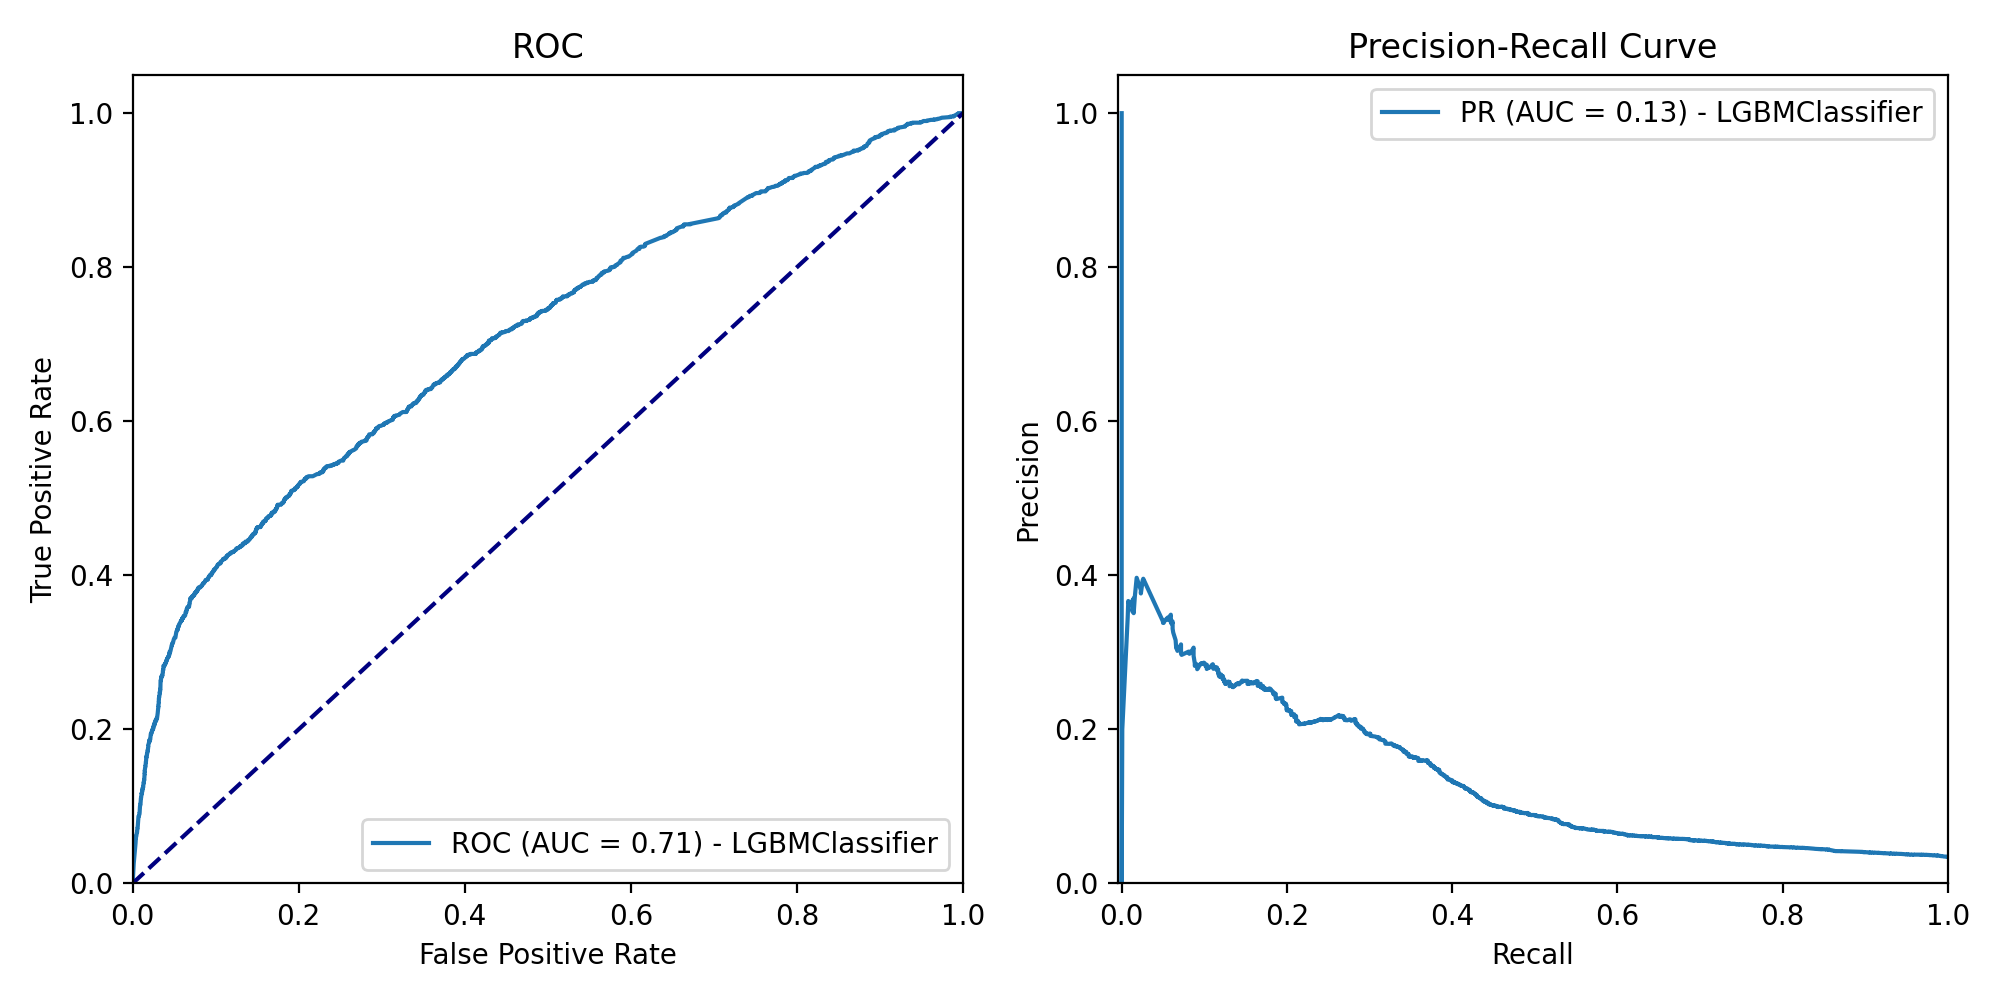

INFO - Precision in the first decile: 0.14
INFO - Uplift by decile:
INFO - decile
0    3.947955
1    1.108694
2    0.792832
3    0.867608
4    0.710678
5    0.696174
6    0.562108
7    0.497531
8    0.532183
9    0.301928
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
351                 WHICH_MONTH_CHURNED          192
150            dif_periodica_prev_month           44
112                       NUM_PERM_CURR           36
3                           periodica_0           24
38                   MIN_DAYS_PERM_CURR           20
74     NUM_DAYS_LINE_TYPE_FIXE_POST_ACT           20
164  service_fix_pending_install_3month           20
183           aperiodica_0_avg_6_months           19
185           aperiodica_0_std_6_months           13
43                   MAX_DAYS_PERM_CURR           12


In [167]:
get_initial_params()
features, target, features_test, target_test = feature_computation(
    clean_data,
    train_from,
    train_to,
    logger,
    save_features_path=save_features_path,
    save_target_path=save_target_path,
)
model = modeling(features, target, lightgbm_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path
)